# Data Analysis Project - Covid Tangerang, Indonesia
Data provider: Pemkot Tangerang via https://maps.tangerangkota.go.id

Isi:
- [Monthly Case Sukasari 2021](#Monthly-Case-Sukasari-2021)
- [Case Per Kecamatan, Kelurahan se-Kota Tangerang 2021](#Case-Per-Kecamatan,-Kelurahan-se-Kota-Tangerang-2021)

In [1]:
def progress(block_num, block_size, total):
    current_size_kb = block_size * block_num #in bytes
    size_kb_mb = round(current_size_kb/1e3, 2) if current_size_kb < 1000 else round(current_size_kb/1e6, 2) 
    satuan = "KB" if current_size_kb < 1000 else "MB"

    print("\rCurrently processing: {} {} ({} B) dari total {} B | BlockSize = {}, BlockNo = {}".format( 
        size_kb_mb, satuan, current_size_kb, total, block_size, block_num
        ), end=""
    )
    
def fetchJsonData():
    import urllib.request as req
    
    print("Proses penarikan data dari maps.tangerangkota.go.id sedang berlangsung. Mohon menunggu...")
    raw_filename = "covid.json"
    url = "https://maps.tangerangkota.go.id/arcgis/rest/services/Kesehatan/covid19_harian/MapServer/0/query?f=json&where=1%3D1&returnGeometry=true&spatialRel=esriSpatialRelIntersects&geometry=%7B%22xmin%22%3A11830868.287569588%2C%22ymin%22%3A-704935.5110923217%2C%22xmax%22%3A11904859.330949666%2C%22ymax%22%3A-673596.3294953874%2C%22spatialReference%22%3A%7B%22wkid%22%3A102100%7D%7D&geometryType=esriGeometryEnvelope&inSR=102100&outFields=objectid%2Ckecamatan%2Ckelurahan%2Csuspek_aktif%2Ckonfirmasi_total%2Ckonfirmasi_dlmperawatan%2Ckonfirmasi_sembuh%2Ckonfirmasi_meninggal%2Ctanggal%2Csumber%2Cketerangan&orderByFields=objectid%20ASC&outSR=102100"
    
    req.urlretrieve(url, filename=raw_filename, reporthook=progress) #proses ambil data
    
    print("\nData berhasil disimpan kedalam file {}".format(raw_filename))
    
    import json #utk baca file format json
    
    file = open("covid.json", "r")
    xx = json.load(file)
    file.close()

    features = xx["features"]

    del file, xx

    extractFileName = "covidfeatures.json"
    print("Proses ekstraksi data menuju file {} sedang berlangsung. Harap menunggu...".format(extractFileName))
    file = open(extractFileName, "w") #buat file baru, atau timpa yg sudah ada (w = write, override | a = write, append)
    data = [] #init list kosong
    for i in range(len(features)):
        if i == 0:
            data.append("{ \"data\": [")
        wr = str(features[i]["attributes"]).replace("'", "\"").replace("None", "null") + "," if (i != len(features) - 1) else str(features[i]["attributes"]).replace("'", "\"").replace("None", "null")

#         tes output dari 10 looping pertama
#         if i < 10:
#             print(wr) 
        
        data.append(wr)
        
        if i == len(features) - 1:
            data.append("]}")

    for y in range(len(data)):
        file.write(str(data[y]))
        
    file.close()
    
    print("Data berhasil diekstrak menuju file {}".format(extractFileName))

Sample tampilan `covid.json`:

<img src="covidjson sample data.jpg" style="border-radius: 10px; box-shadow: 1px 1px 5px black" />

In [2]:
import pandas as p
import matplotlib.pyplot as plot

#Abaikan output yg sifatnya warning (bukan error/exception)
import warnings
warnings.filterwarnings("ignore")

#utk tarik data
# fetchJsonData()

In [3]:
#item = p.read_csv("Rekapitulasi Harian COVID19 2.0.csv", na_values=" NaN")
#item = p.read_csv("Rekapitulasi Harian COVID19 v3.csv", na_values=" NaN")

item2 = p.read_json("covidfeatures.json", lines=False, orient="split", convert_dates=["tanggal"])

In [4]:
# Filter data; hilangin yg None
item2 = item2[item2["kecamatan"].notnull()]

In [5]:
# Cek data
item2.sample(2)

,objectid,kecamatan,kelurahan,suspek_aktif,konfirmasi_total,konfirmasi_dlmperawatan,konfirmasi_sembuh,konfirmasi_meninggal,tanggal,sumber,keterangan
1386,1491,Karawaci,Gerendeng,2.0,0.0,0.0,0.0,0.0,2020-03-22 07:00:00,Dinas Kesehatan Kota Tangerang,None
35014,41815,Cibodas,Cibodas Baru,19.0,91.0,3.0,83.0,5.0,2021-02-18 03:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...


In [6]:
# covid.json (data mentah dari maps.tangerangkota.go.id) punya heading utk "translate" setiap column name kedlm bentukan
# yg mudah dibaca manusia. 
# Posisi: "fieldAliases"
import json
file = open("covid.json", "r")
parsed_json = json.load(file)
file.close()

parsed_json["fieldAliases"]


{'objectid': 'objectid',
 'kecamatan': 'Kecamatan',
 'kelurahan': 'Kelurahan',
 'suspek_aktif': 'Suspek dlm Perawatan',
 'konfirmasi_total': 'Konfirmasi Total',
 'konfirmasi_dlmperawatan': 'Konfirmasi dlm Perawatan',
 'konfirmasi_sembuh': 'Konfirmasi Sembuh',
 'konfirmasi_meninggal': 'Konfirmasi Meninggal',
 'tanggal': 'Tanggal',
 'sumber': 'Sumber Data',
 'keterangan': 'Keterangan'}

Deskripsi kolom (via https://maps.tangerangkota.go.id/corona/)

>**Suspek Aktif Dirawat**: Seseorang yang memiliki **gejala/tanda ISPA dan pneumonia berat** yang membutuhkan perawatan di RS
>
>**Terkonfirmasi**: Seseorang yang dinyatakan positif COVID-19 setelah melalui pemeriksaan lab **RT-PCR**
>
>(Konfirmasi) **Dalam Perawatan**: Seseorang yang masih dalam masa perawatan COVID-19
>
>(Konfirmasi) **Sembuh**: Seseorang yang sembuh dari COVID-19
>
>(Konfirmasi) **Meninggal**: Seseorang yang meninggal akibat COVID-19

In [7]:
#Pakai fieldAiases utk rename nama kolom:

# item2.rename(columns = {
#     "objectid":"objectid", "kecamatan":"Kecamatan", "kelurahan":"Kelurahan",
#     "suspek_aktif":"Suspek dlm Perawatan","konfirmasi_total":"Konfirmasi Total",
#     "konfirmasi_dlmperawatan":"Konfirmasi dlm Perawatan","konfirmasi_sembuh":"Konfirmasi Sembuh",
#     "konfirmasi_meninggal":"Konfirmasi Meninggal","tanggal":"Tanggal",
#     "sumber":"Sumber Data","keterangan":"Keterangan"
# }, inplace=True)


item2.rename(columns = parsed_json["fieldAliases"], inplace=True)

In [8]:
item2.sample(3)

,objectid,Kecamatan,Kelurahan,Suspek dlm Perawatan,Konfirmasi Total,Konfirmasi dlm Perawatan,Konfirmasi Sembuh,Konfirmasi Meninggal,Tanggal,Sumber Data,Keterangan
47203,55189,Pinang,Pakojan,0.0,21.0,0.0,21.0,0.0,2021-06-14 03:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...
37431,44232,Larangan,Larangan Selatan,21.0,98.0,4.0,93.0,1.0,2021-03-13 03:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...
12476,14301,Tangerang,Cikokol,9.0,17.0,1.0,16.0,0.0,2020-07-16 03:00:00,Dinas Kesehatan Kota Tangerang,None


In [9]:
item2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53456 entries, 0 to 53767
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   objectid                  53456 non-null  int64         
 1   Kecamatan                 53456 non-null  object        
 2   Kelurahan                 53456 non-null  object        
 3   Suspek dlm Perawatan      53456 non-null  float64       
 4   Konfirmasi Total          53456 non-null  float64       
 5   Konfirmasi dlm Perawatan  53456 non-null  float64       
 6   Konfirmasi Sembuh         53456 non-null  float64       
 7   Konfirmasi Meninggal      53456 non-null  float64       
 8   Tanggal                   53456 non-null  datetime64[ns]
 9   Sumber Data               53456 non-null  object        
 10  Keterangan                34194 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 4.9+ MB


In [10]:
#Pecah tanggal utk drill-down
item2["Quarter"] = [x.quarter for x in item2["Tanggal"]]
item2["Year"] = [x.year for x in item2["Tanggal"]]
item2["Month"] = [x.month for x in item2["Tanggal"]]
item2["Day"] = [x.day for x in item2["Tanggal"]]


## Sorting DataFrame

In [11]:
#sortedData = dataFiltered.sort_values(by = "DateParsed", ascending=False)

sortedData = item2.sort_values(by = "Tanggal", ascending=False)

In [12]:
#reset index setelah sorting, drop=True --> jangan tambah kolom 
#utk catat index lama
sortedData = sortedData.reset_index(drop=True) 

In [13]:
sortedData.head(2)

,objectid,Kecamatan,Kelurahan,Suspek dlm Perawatan,Konfirmasi Total,Konfirmasi dlm Perawatan,Konfirmasi Sembuh,Konfirmasi Meninggal,Tanggal,Sumber Data,Keterangan,Quarter,Year,Month,Day
0,61961,Karawaci,Margasari,8.0,176.0,9.0,159.0,8.0,2021-08-17 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,17
1,61909,Pinang,Kunciran Jaya,0.0,82.0,0.0,78.0,4.0,2021-08-17 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,17


**Tes filter data**:

In [14]:
# sortedData[(sortedData["Konfirmasi Total"] > 10) & (sortedData["Konfirmasi Total"] < 15)]

In [15]:
sortedData[ sortedData.Kelurahan == "Sukajadi" ]

,objectid,Kecamatan,Kelurahan,Suspek dlm Perawatan,Konfirmasi Total,Konfirmasi dlm Perawatan,Konfirmasi Sembuh,Konfirmasi Meninggal,Tanggal,Sumber Data,Keterangan,Quarter,Year,Month,Day
92,61912,Karawaci,Sukajadi,3.0,172.0,18.0,149.0,5.0,2021-08-17 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,17
186,61808,Karawaci,Sukajadi,3.0,172.0,18.0,149.0,5.0,2021-08-16 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,16
290,61704,Karawaci,Sukajadi,3.0,172.0,23.0,144.0,5.0,2021-08-15 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,15
389,61600,Karawaci,Sukajadi,3.0,171.0,24.0,142.0,5.0,2021-08-14 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,14
498,61496,Karawaci,Sukajadi,3.0,168.0,24.0,140.0,4.0,2021-08-13 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52945,1493,Karawaci,Sukajadi,0.0,0.0,0.0,0.0,0.0,2020-03-22 07:00:00,Dinas Kesehatan Kota Tangerang,None,1,2020,3,22
53043,1389,Karawaci,Sukajadi,0.0,0.0,0.0,0.0,0.0,2020-03-21 07:00:00,Dinas Kesehatan Kota Tangerang,None,1,2020,3,21
53158,1287,Karawaci,Sukajadi,0.0,0.0,0.0,0.0,0.0,2020-03-20 09:00:00,Dinas Kesehatan Kota Tangerang,None,1,2020,3,20
53250,1182,Karawaci,Sukajadi,0.0,0.0,0.0,0.0,0.0,2020-03-19 09:00:00,Dinas Kesehatan Kota Tangerang,None,1,2020,3,19


Karena data `Konfirmasi Total`, `Konfirmasi Sembuh`, dan `Konfirmasi Meninggal` sifatnya akumulasi day-to-day <br>
Maka utk cari nilai hariannya (per-kelurahan):

In [16]:
#Karena data Konfirmasi Total, Konfirmasi Sembuh dan Konfirmasi Meninggal sifatnya akumulasi day-to-day
#Maka utk cari nilai hariannya (per-kelurahan):
#init kolom kosong
sortedData["confTotal_daily"] = p.Series()
sortedData["confSembuh_daily"] = p.Series()
sortedData["confMeninggal_daily"] = p.Series()
sortedData.sample(1)

,objectid,Kecamatan,Kelurahan,Suspek dlm Perawatan,Konfirmasi Total,Konfirmasi dlm Perawatan,Konfirmasi Sembuh,Konfirmasi Meninggal,Tanggal,Sumber Data,Keterangan,Quarter,Year,Month,Day,confTotal_daily,confSembuh_daily,confMeninggal_daily
31071,25876,Pinang,Pakojan,0.0,5.0,1.0,4.0,0.0,2020-10-20 03:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,4,2020,10,20,NaN,NaN,NaN


In [17]:
kelurahan = sortedData.Kelurahan.unique() #Ambil semua nama kelurahan yang ada 
for nama in kelurahan:
    currentData = sortedData.sort_values(by="Tanggal", ascending=True)[ sortedData.Kelurahan == nama ]
    currentData["confTotal_daily"] = currentData["Konfirmasi Total"].diff().fillna(currentData["Konfirmasi Total"])
    currentData["confSembuh_daily"] = currentData["Konfirmasi Sembuh"].diff().fillna(currentData["Konfirmasi Sembuh"])
    currentData["confMeninggal_daily"] = currentData["Konfirmasi Meninggal"].diff().fillna(currentData["Konfirmasi Meninggal"])
    
    sortedData["confTotal_daily"].update(currentData["confTotal_daily"])
    sortedData["confSembuh_daily"].update(currentData["confSembuh_daily"])
    sortedData["confMeninggal_daily"].update(currentData["confMeninggal_daily"])


In [18]:
sortedData[ sortedData["Kelurahan"] == "Sukarasa" ]

,objectid,Kecamatan,Kelurahan,Suspek dlm Perawatan,Konfirmasi Total,Konfirmasi dlm Perawatan,Konfirmasi Sembuh,Konfirmasi Meninggal,Tanggal,Sumber Data,Keterangan,Quarter,Year,Month,Day,confTotal_daily,confSembuh_daily,confMeninggal_daily
54,61936,Tangerang,Sukarasa,1.0,136.0,12.0,122.0,2.0,2021-08-17 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,17,1.0,1.0,0.0
156,61832,Tangerang,Sukarasa,1.0,135.0,12.0,121.0,2.0,2021-08-16 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,16,0.0,1.0,0.0
260,61728,Tangerang,Sukarasa,1.0,135.0,13.0,120.0,2.0,2021-08-15 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,15,1.0,1.0,0.0
392,61624,Tangerang,Sukarasa,1.0,134.0,13.0,119.0,2.0,2021-08-14 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,14,0.0,1.0,0.0
468,61520,Tangerang,Sukarasa,1.0,134.0,14.0,118.0,2.0,2021-08-13 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,13,1.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53012,1512,Tangerang,Sukarasa,0.0,0.0,0.0,0.0,0.0,2020-03-22 07:00:00,Dinas Kesehatan Kota Tangerang,None,1,2020,3,22,0.0,0.0,0.0
53092,1408,Tangerang,Sukarasa,0.0,0.0,0.0,0.0,0.0,2020-03-21 07:00:00,Dinas Kesehatan Kota Tangerang,None,1,2020,3,21,0.0,0.0,0.0
53231,1306,Tangerang,Sukarasa,0.0,0.0,0.0,0.0,0.0,2020-03-20 09:00:00,Dinas Kesehatan Kota Tangerang,None,1,2020,3,20,0.0,0.0,0.0
53325,1201,Tangerang,Sukarasa,0.0,0.0,0.0,0.0,0.0,2020-03-19 09:00:00,Dinas Kesehatan Kota Tangerang,None,1,2020,3,19,0.0,0.0,0.0


## Monthly Case Sukasari 2021
- Kelurahan = Sukasari
- Tahun = 2021

In [19]:
sukasari_2021 = sortedData[(sortedData.Kelurahan == "Sukasari") & (sortedData.Year == 2021)]


In [20]:
sukasari_2021.head(3)

,objectid,Kecamatan,Kelurahan,Suspek dlm Perawatan,Konfirmasi Total,Konfirmasi dlm Perawatan,Konfirmasi Sembuh,Konfirmasi Meninggal,Tanggal,Sumber Data,Keterangan,Quarter,Year,Month,Day,confTotal_daily,confSembuh_daily,confMeninggal_daily
36,61865,Tangerang,Sukasari,10.0,477.0,28.0,433.0,16.0,2021-08-17 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,17,3.0,2.0,0.0
138,61760,Tangerang,Sukasari,10.0,474.0,27.0,431.0,16.0,2021-08-16 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,16,1.0,3.0,0.0
243,61656,Tangerang,Sukasari,10.0,473.0,29.0,428.0,16.0,2021-08-15 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,15,0.0,7.0,0.0


**%Mortality Rate: perbandingan kasus kematian dibagi total case yg ada**

In [21]:
#total_case = sukasari_2021.iloc[0]["Konfirmasi Sembuh"] + sukasari_2021.iloc[0]["Konfirmasi Meninggal"] + sukasari_2021.iloc[0]["Konfirmasi dlm Perawatan"]
total_case = sukasari_2021.iloc[0]["Konfirmasi Total"]
mortality_rate = str(
    round(
        sukasari_2021.iloc[0]["Konfirmasi Meninggal"] / total_case * 100, 2
    )
) + "%"

In [22]:
print("""
Dari {total} case yg terjadi selama 2021 di Sukasari, terdapat kematian sebanyak {death} case
sehingga rasio mortalitasnya adalah {mortality_rate}
""".format(total = total_case, death = sukasari_2021.iloc[0]["Konfirmasi Meninggal"], mortality_rate = mortality_rate))


Dari 477.0 case yg terjadi selama 2021 di Sukasari, terdapat kematian sebanyak 16.0 case
sehingga rasio mortalitasnya adalah 3.35%



In [23]:
sukasari_2021.head(2)

,objectid,Kecamatan,Kelurahan,Suspek dlm Perawatan,Konfirmasi Total,Konfirmasi dlm Perawatan,Konfirmasi Sembuh,Konfirmasi Meninggal,Tanggal,Sumber Data,Keterangan,Quarter,Year,Month,Day,confTotal_daily,confSembuh_daily,confMeninggal_daily
36,61865,Tangerang,Sukasari,10.0,477.0,28.0,433.0,16.0,2021-08-17 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,17,3.0,2.0,0.0
138,61760,Tangerang,Sukasari,10.0,474.0,27.0,431.0,16.0,2021-08-16 07:00:00,Dinas Kesehatan Kota Tangerang,Data sebaran Coronavirus COVID-19 yang disajik...,3,2021,8,16,1.0,3.0,0.0


In [24]:
sukasari_2021_monthly_case = sukasari_2021.groupby(["Month", "Day"], as_index=False)[["Suspek dlm Perawatan","Konfirmasi dlm Perawatan", "Konfirmasi Sembuh", "Konfirmasi Meninggal",
                                                                                     "confTotal_daily", "confSembuh_daily", "confMeninggal_daily"
                                                                                     ]].sum()

In [25]:
sukasari_2021_monthly_case

,Month,Day,Suspek dlm Perawatan,Konfirmasi dlm Perawatan,Konfirmasi Sembuh,Konfirmasi Meninggal,confTotal_daily,confSembuh_daily,confMeninggal_daily
0,1,1,34.0,4.0,50.0,1.0,2.0,0.0,0.0
1,1,2,37.0,3.0,51.0,1.0,0.0,1.0,0.0
2,1,3,33.0,4.0,51.0,1.0,1.0,0.0,0.0
3,1,4,27.0,4.0,51.0,1.0,0.0,0.0,0.0
4,1,5,27.0,3.0,52.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
221,8,13,9.0,40.0,414.0,16.0,1.0,8.0,0.0
222,8,14,10.0,36.0,421.0,16.0,3.0,7.0,0.0
223,8,15,10.0,29.0,428.0,16.0,0.0,7.0,0.0
224,8,16,10.0,27.0,431.0,16.0,1.0,3.0,0.0


In [26]:
plot.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [27]:
plot.style.use("bmh")

Help on method plot in module matplotlib.axes._axes:

plot(*args, scalex=True, scaley=True, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the ap

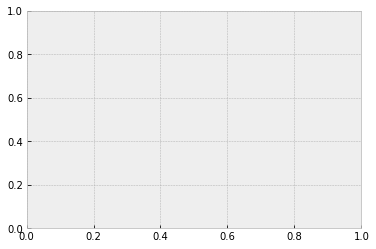

In [28]:
help(plot.figure().add_subplot().plot)

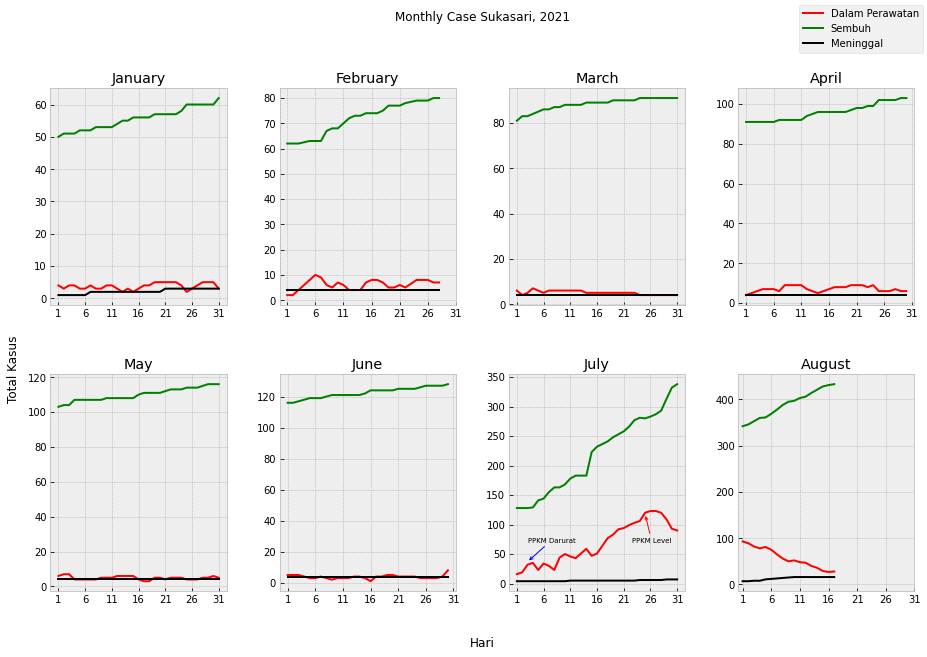

In [29]:
import calendar

figure = plot.figure( figsize=(12,6) )
for month in range(1, sukasari_2021_monthly_case.Month.max() + 1):
    monthly = sukasari_2021_monthly_case[ sukasari_2021_monthly_case["Month"] == month ]
    axis = figure.add_subplot(9,4,month)
    axis.plot(monthly["Day"], monthly[["Konfirmasi dlm Perawatan"]], "-", color="r")
    axis.plot(monthly["Day"], monthly[["Konfirmasi Sembuh"]], "-", color="g")
    axis.plot(monthly["Day"], monthly[["Konfirmasi Meninggal"]],"-", color="#000000")
   
    axis.set_xticks(range(1,32, 5))
    
    axis.set_title(calendar.month_name[month])
    
    if month == 7:  #khusus plot di bulan Juli
        axis.annotate("PPKM Level", (25,118),fontsize=7, arrowprops={"arrowstyle": "->", "color": "red", "lw": 1}, xytext=(22.5,70))
        axis.annotate("PPKM Darurat", (3, 37), fontsize=7, arrowprops={"arrowstyle": "->", "color":"blue", "lw": 1}, xytext=(3, 70) )

figure.legend(["Dalam Perawatan", "Sembuh", "Meninggal"])
figure.supylabel("Total Kasus", x=-.05 , y=0.15 )
figure.supxlabel("Hari", y=-.5)
figure.suptitle("Monthly Case Sukasari, 2021");


plot.subplots_adjust( bottom=-5, top=0.8, left=0, right=1, hspace=0.32, wspace=0.3)
# plot.subplots_adjust(wspace=0.2, hspace=1)

### Case Per Kecamatan, Kelurahan se-Kota Tangerang 2021

- Jumlah Kasus COVID-19 Per Kecamatan, 2021
- Kasus Konfirmasi Total Tertinggi Berdasarkan Kasus Tertinggi setiap Kecamatan 2021
- Top 5 Kasus Konfirmasi Total Tertinggi Kelurahan se-Tangerang Kota 2021

In [30]:
case_2021 = sortedData[ sortedData.Year == 2021 ]
max_kecamatan = case_2021.groupby(["Kecamatan"], as_index=False)["Konfirmasi Total"].idxmax()
max_kecamatan.rename(columns={"Konfirmasi Total": "KT_Index"}, inplace=True)

case_per_kecamatan = case_2021.iloc[max_kecamatan["KT_Index"]]

In [31]:
case_per_kecamatan.sort_values(by = "Konfirmasi Total", ascending=False, inplace=True)

In [32]:
kecamatan_overall = case_2021.groupby("Kecamatan", as_index=False).sum()
kecamatan_overall["confTotal_daily"] = abs(kecamatan_overall["confTotal_daily"] - (kecamatan_overall["confSembuh_daily"] + kecamatan_overall["confMeninggal_daily"]))
kecamatan_overall.sort_values(by=["confSembuh_daily", "confTotal_daily", "confMeninggal_daily"], ascending=False, inplace=True)

In [33]:
max_kelurahan = case_2021.groupby("Kelurahan", as_index=False)["Konfirmasi Total"].idxmax()
case_per_kel = case_2021.iloc[ max_kelurahan["Konfirmasi Total"] ]
case_per_kel.sort_values(by = "Konfirmasi Total", ascending=False, inplace=True)

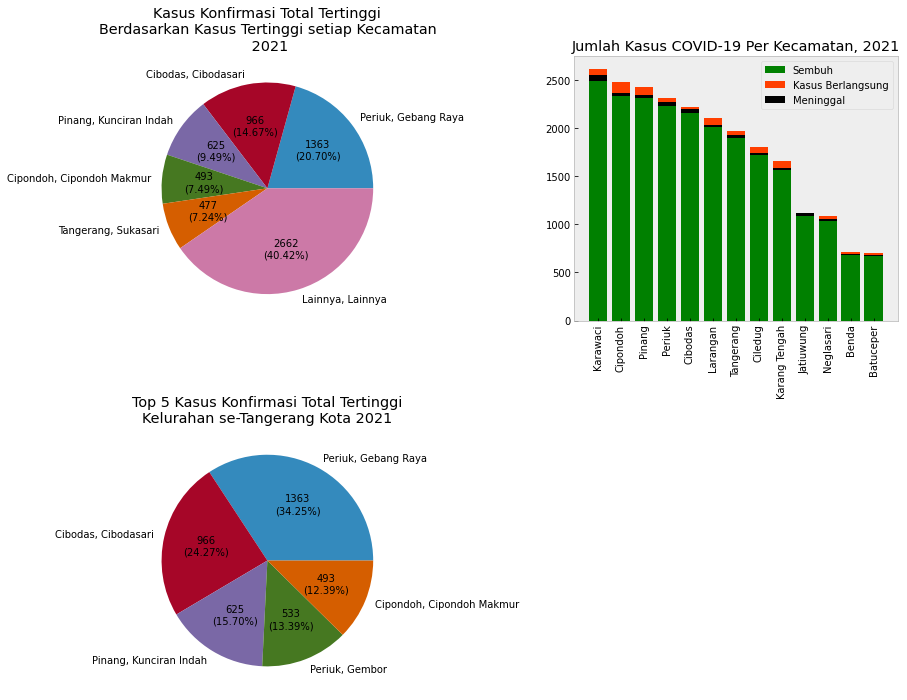

In [34]:
# case_per_kecamatan.plot(kind="pie", y=["Konfirmasi Total", "Konfirmasi Meninggal"], yticks=range(0, 250, 50), xticks=["ads"], rot=90)
figure = plot.figure(figsize=(10,15))

# plot.rcParams["text.antialiased"] = True
# plot.rcParams["text.color"] = "black"
# plot.rcParams["font.weight"] = 600
# plot.rcParams["font.size"] = 14
# plot.rcParams["font.style"] ="normal"
# plot.rcParams["font.family"] = "Roboto"
###

axis = figure.add_subplot(3,2,1)

top5 = case_per_kecamatan[:5]
others = case_per_kecamatan[5:].sum()
others["Kecamatan"] = others["Kelurahan"] = "Lainnya"
merge = top5.append(others, ignore_index=True)
merge["Camat_Lurah"] = merge["Kecamatan"] + ", " + merge["Kelurahan"]

totals = merge["Konfirmasi Total"]
axis.pie(merge["Konfirmasi Total"], counterclock=True, labels = merge.Camat_Lurah, autopct= lambda x: "{:.0f}\n({:.2f}%)".format(x * totals.sum()/100, x)  );
axis.set_title("Kasus Konfirmasi Total Tertinggi\nBerdasarkan Kasus Tertinggi setiap Kecamatan\n 2021");

axis = figure.add_subplot(3,2,2)
axis.bar(data=kecamatan_overall, x="Kecamatan", height="confSembuh_daily", color="green")
axis.bar(data=kecamatan_overall, x="Kecamatan", height="confTotal_daily", color="#ff3f00", bottom="confSembuh_daily")
axis.bar(data=kecamatan_overall, x="Kecamatan", height="confMeninggal_daily", bottom="confSembuh_daily", color="black")

axis.legend(["Sembuh", "Kasus Berlangsung", "Meninggal"])
axis.set_title("Jumlah Kasus COVID-19 Per Kecamatan, 2021")
plot.xticks(rotation="vertical");
axis.grid()

axis = figure.add_subplot(3,2,3)
top5_kel = case_per_kel[:5]
# bottom5_kel = case_per_kel[5:11].sum()
# bottom5_kel["Kecamatan"] = bottom5_kel["Kelurahan"] = "Lainnya"
# merge = top5_kel.append(bottom5_kel, ignore_index=True)

top5_kel["Camat_Lurah"] = top5_kel["Kecamatan"] + ", " + top5_kel["Kelurahan"]
totals = top5_kel["Konfirmasi Total"]

axis.set_title("Top 5 Kasus Konfirmasi Total Tertinggi\nKelurahan se-Tangerang Kota 2021")
axis.pie(totals, counterclock=True, labels=top5_kel.Camat_Lurah,  autopct= lambda x: "{:.0f}\n({:.2f}%)".format(x * totals.sum()/100, x) );

plot.tight_layout(h_pad=3,w_pad=3, rect=(0,0,1.3,1))
plot.savefig("inifig.jpg", bbox_inches="tight", pad_inches=0.75, dpi=200)